# Generating cloud masks from satellite imagery - Part I 

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4)
* [Method 1: Cloud mask using Sentinel Cloudless](#4a)    
    * [Data Preparation](#5)
       * [Define the Area of Interest in NYC](#6)
       * [Visualize Area of Interest in NYC](#7) 
       * [Convert scene to array](#8)    
    * [Initiate cloud detector](#9)  
    * [Generate cloud mask](#10) 
    * [Visualize the cloud mask](#11)
* [Method 2: Cloud mask using unsupervised learning](#12)
    * [Accessing & Visualizing datasets](#13)
    * [Data Pre-processing](#14)
    * [Model Initialization](#15) 
    * [Model Training](#16)
    * [Cloud Prediction](#17) 
    * [Result Visualization](#18) 
* [Conclusion](#19)
* [Data resources](#20)

## Introduction <a class="anchor" id="1"></a>

This notebook describes the different ways cloud masks can be generated from satellite imagery, in this instance using sentinel imagery.

Cloud presence causes problems for remote sensing analysis of surface properties, for instance in analyses like land use and land cover classification, image compositing, or change detection. In cases of single scene image processing, it is relatively easy to manually filter out clouds; however, for studies that use a larger number of images, an automated approach for removing or masking out clouds is necessary.

In parts 1 and 2 of this notebook series, we will demonstrate three methods of cloud mask extraction:

- First, we use the sentinel2 cloudless python package, which is Sentinel's hub cloud detector that works only on sentinel imagery.

- Second, an unsupervised model using the mlmodel framework is applied to generate a cloud mask. This can run on any kind of imagery.

- Third, we train a pixel classifier model based on Unet.

The first two methods are described in this notebook, while the third method is described in the second part of the notebook series, along with a comparison of the results of the three different methods.

## Imports <a class="anchor" id="2"></a>

Here, we import the modules we will be using in this notebook, including the pixel cloud detector from the Sentinel Cloudless package.

In [1]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime as dt

import arcgis
from arcgis.gis import GIS
from arcgis.learn import MLModel, prepare_tabulardata
from arcgis.raster import Raster

from fastai.vision import *

The Sentinel cloudless package can be installed using the following commands:

In [ ]:
pip install sentinelhub --upgrade

pip install s2cloudless

In [2]:
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest, get_s2_evalscript

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [3]:
gis = GIS("home")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a>

Next, we will access the Sentinel-2 imagery, which has a high resolution of 10m and has 13 bands. This imagery can be accessed from the ArcGIS Enterprise portal, where it is sourced from the AWS collection.

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
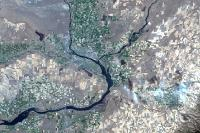

In [4]:
# get image
s2 = gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

## Method 1: Cloud mask using Sentinel Cloudless <a class="anchor" id="4a"></a>

### Data Preparation <a class="anchor" id="5"></a>

#### Define the Area of Interest in NYC <a class="anchor" id="6"></a>
The area of interest is defined using the four latitude and longitude values from a certain part of NYC with cloud presence, as can be seen from the images.

In [6]:
#  extent in 3857 for NYU rain clouds
NYU_cloud_extent = {
    "xmin": -8231176.77,
    "ymin": 4967559.25,
    "xmax": -8242898.16,
    "ymax": 4973524.61,
    "spatialReference": {"wkid": 3857}
}

In [7]:
# NYU - The respective scene having the above area is selected
selected = sentinel.filter_by(where="(Category = 1) AND (cloudcover >=0.05)",                              
                              geometry=arcgis.geometry.filters.intersects(NYU_cloud_extent))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
0,4241924,2021-03-16 16:01:47,20210316T160146_18TWL_0,1.0000,75,"{""rings"": [[[-8213212.075300001, 4963896.74279...",2021-03-16 16:01:47
1,4237238,2021-03-18 15:51:50,20210318T155150_18TWL_0,1.0000,77,"{""rings"": [[[-8204375.4298, 4983638.8807], [-8...",2021-03-18 15:51:50
2,4295242,2021-03-23 15:51:50,20210323T155149_18TWL_0,0.4003,82,"{""rings"": [[[-8204375.4298, 4983638.8838], [-8...",2021-03-23 15:51:50
3,4331225,2021-03-26 16:01:45,20210326T160145_18TWL_0,0.2615,85,"{""rings"": [[[-8208581.755000001, 4979145.44569...",2021-03-26 16:01:45
4,4357851,2021-03-28 15:51:50,20210328T155149_18TWL_0,1.0000,87,"{""rings"": [[[-8202748.8665, 5092663.800099999]...",2021-03-28 15:51:50
...,...,...,...,...,...,...,...
135,8795350,2022-04-27 15:51:56,20220427T155156_18TWL_0,0.7319,117,"{""rings"": [[[-8204375.4296, 4983638.886600003]...",2022-04-27 15:51:56
136,8829566,2022-04-30 16:01:52,20220430T160152_18TWL_0,0.2307,120,"{""rings"": [[[-8208559.822899999, 4979109.30569...",2022-04-30 16:01:52
137,8853845,2022-05-02 15:51:45,20220502T155145_18TWL_0,1.0000,122,"{""rings"": [[[-8204375.429300001, 4983638.90709...",2022-05-02 15:51:45
138,8888388,2022-05-05 16:01:43,20220505T160142_18TWL_0,0.9993,125,"{""rings"": [[[-8212688.777000001, 4963035.21440...",2022-05-05 16:01:43


#### Visualize Area of Interest in NYC <a class="anchor" id="7"></a>

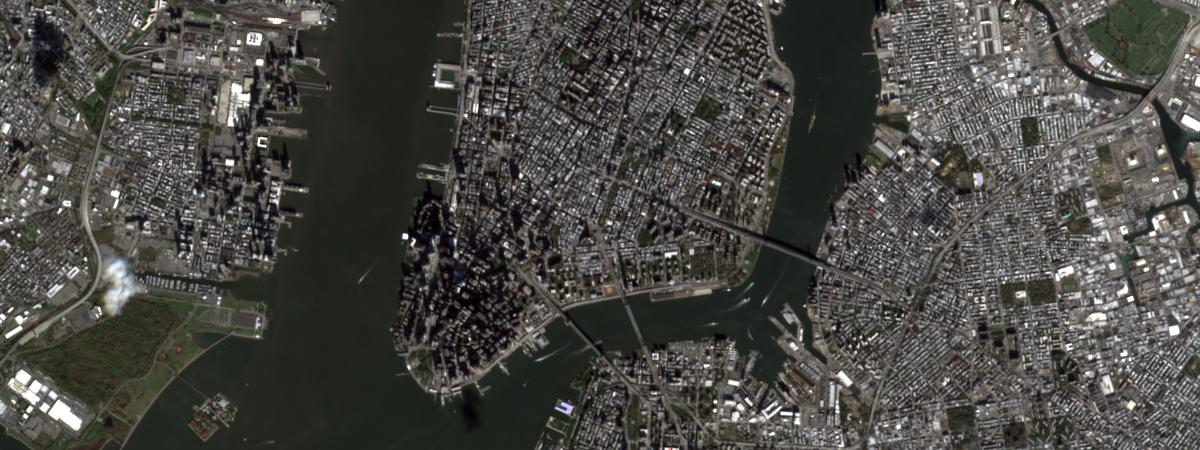

In [8]:
# The scene is selected with the least cloud cover and extracted using the selected NYC extent
NYU_clouds_scene4 = sentinel.filter_by('OBJECTID=352211')
NYU_clouds_scene4.extent = NYU_cloud_extent
NYU_clouds_scene4

In [9]:
from arcgis.raster.functions import apply

In [10]:
s2_ms = apply(NYU_clouds_scene4, None)

In [11]:
pd.DataFrame(s2_ms.key_properties()['BandProperties'])

,BandName,WavelengthMin,WavelengthMax
0,B1_Aerosols,433,453
1,B2_Blue,458,522
2,B3_Green,543,577
3,B4_Red,650,680
4,B5_RedEdge,698,712
5,B6_RedEdge,733,747
6,B7_RedEdge,773,793
7,B8_NearInfraRed,784,899
8,B8A_NarrowNIR,855,875
9,B9_WaterVapour,935,955


#### Convert scene to arrray <a class="anchor" id="8"></a>

In [12]:
# convert the scene to a numpy array
test_array = s2_ms.export_image(f='numpy_array')

In [13]:
test_array.shape

(450, 1200, 13)

In [14]:
# Change array to float data type
test_array_sr = test_array/10000
test_array_sr = test_array_sr.astype('float32')

### Initiate cloud detector <a class="anchor" id="9"></a>
Finally, the cloud detector can be initiated using specified parameters. The values can be adjusted for different amounts of cloud cover.

In [15]:
# Initiate sentinel cloud detector 
cloud_detector = S2PixelCloudDetector(
    threshold=0.7,
    average_over=4,
    dilation_size=2,
    all_bands=True
)

### Generate cloud mask <a class="anchor" id="10"></a>

Once initiated, the cloud detector can be used to extract the cloud mask from the chosen scene.

In [16]:
%%time
test_cloud_mask = cloud_detector.get_cloud_masks(test_array_sr)

Wall time: 2.85 s


In [17]:
test_cloud_mask.shape

(450, 1200)

In [18]:
test_cloud_mask

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=int8)

### Visualize the cloud mask<a class="anchor" id="11"></a>

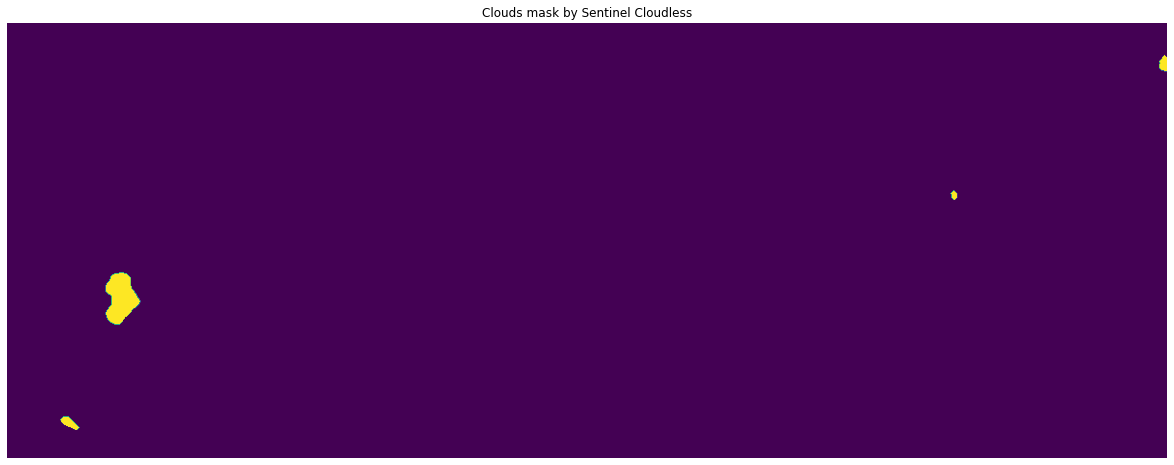

In [20]:
plt.figure(figsize=(25,8))
plt.imshow(test_cloud_mask)
plt.title('Clouds mask by Sentinel Cloudless')
plt.axis('off')
plt.show()

Upon successfully visualizing the results, we can see that the clouds have been detected properly, separating the actual clouds from other objects with similar appearance.

Next, a different scene with clouds over forested areas will be tested with the same workflow used above. First, an area of interest is  defined, then that scene is converted to an array to which the the cloud detector is appllied, resulting in a final cloud mask.

In [21]:
#  extent in 3857 for amazon rain clouds
cloud_extent = {
    "xmin": -6501664.396,
    "ymin": -610686.285,
    "xmax": -6490039.703,
    "ymax": -600222.721,
    "spatialReference": {"wkid": 3857}
}

In [22]:
# The respective scene having the above area is selected
selected = sentinel.filter_by(where="(Category = 1) AND (cloudcover >=0.05)",                              
                              geometry=arcgis.geometry.filters.intersects(cloud_extent))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
0,4179505,2021-03-13 14:24:00,20210313T142359_21MUQ_0,0.9761,72,"{""rings"": [[[-6454184.5053, -600807.9221000001...",2021-03-13 14:24:00
1,4179509,2021-03-13 14:24:14,20210313T142414_21MUP_0,0.9853,72,"{""rings"": [[[-6476198.8497, -702069.1108000018...",2021-03-13 14:24:14
2,4236405,2021-03-18 14:23:59,20210318T142359_21MUQ_0,0.9966,77,"{""rings"": [[[-6447913.4047, -573839.8112000003...",2021-03-18 14:23:59
3,4236409,2021-03-18 14:24:14,20210318T142414_21MUP_0,0.9999,77,"{""rings"": [[[-6460798.414899999, -633008.85029...",2021-03-18 14:24:14
4,4294390,2021-03-23 14:23:59,20210323T142358_21MUQ_0,0.8802,82,"{""rings"": [[[-6453754.216600001, -601144.96370...",2021-03-23 14:23:59
...,...,...,...,...,...,...,...
149,8794512,2022-04-27 14:24:20,20220427T142419_21MUP_0,0.9294,117,"{""rings"": [[[-6461088.789899999, -632967.87530...",2022-04-27 14:24:20
150,8853012,2022-05-02 14:23:55,20220502T142354_21MUQ_0,0.9954,122,"{""rings"": [[[-6449537.895099999, -583912.98730...",2022-05-02 14:23:55
151,8853016,2022-05-02 14:24:09,20220502T142409_21MUP_0,0.9707,122,"{""rings"": [[[-6460231.455399999, -632979.51350...",2022-05-02 14:24:09
152,8911531,2022-05-07 14:24:05,20220507T142404_21MUQ_0,0.9896,127,"{""rings"": [[[-6449574.7908, -584023.4871000014...",2022-05-07 14:24:05


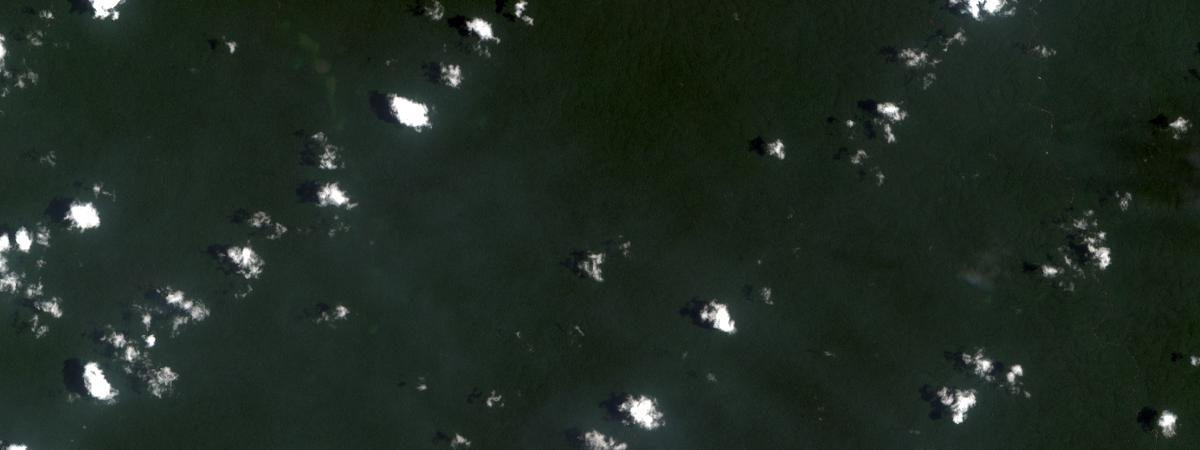

In [23]:
# The scene is selected with the least cloud cover and extracted using the amzon extent
amazon_clouds_scene3 = sentinel.filter_by('OBJECTID=6738997')
amazon_clouds_scene3.extent = cloud_extent
amazon_clouds_scene3

In [24]:
s2_amazon_ms = apply(amazon_clouds_scene3, None)

In [25]:
pd.DataFrame(s2_amazon_ms.key_properties()['BandProperties'])

,BandName,WavelengthMin,WavelengthMax
0,B1_Aerosols,433,453
1,B2_Blue,458,522
2,B3_Green,543,577
3,B4_Red,650,680
4,B5_RedEdge,698,712
5,B6_RedEdge,733,747
6,B7_RedEdge,773,793
7,B8_NearInfraRed,784,899
8,B8A_NarrowNIR,855,875
9,B9_WaterVapour,935,955


In [26]:
test_array = s2_amazon_ms.export_image(f='numpy_array')
test_array_sr = test_array/10000
test_array_sr = test_array_sr.astype('float32')

In [27]:
# Initiate sentinel cloud detector 
cloud_detector = S2PixelCloudDetector(
    threshold=0.3,
    average_over=4,
    dilation_size=2,
    all_bands=True
)

In [28]:
%%time
test_cloud_mask = cloud_detector.get_cloud_masks(test_array_sr)

Wall time: 2.9 s


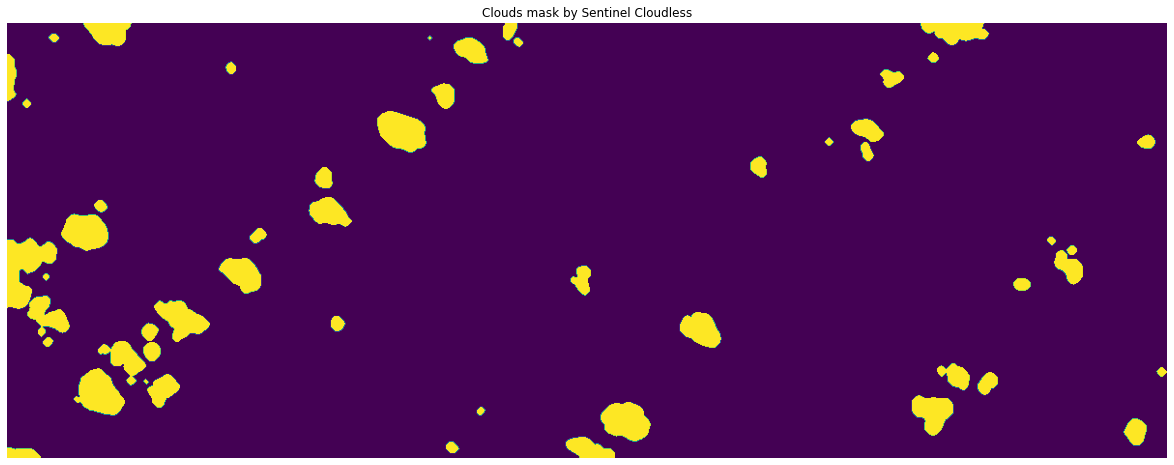

In [29]:
plt.figure(figsize=(25,8))
plt.imshow(test_cloud_mask)
plt.title('Clouds mask by Sentinel Cloudless')
plt.axis('off')
plt.show()

The results show the clouds detected as yellow pixels, with some light clouds not originally visible in the scene being detected in the left portion of the image. The parameters of the cloud detector can be changed to detect different intensities of clouds.

## Method 2: Cloud mask using unsupervised learning <a class="anchor" id="12"></a>

In this section, the unsupervised learning method of k-means clustering is used for cloud detection. First, a scene from a preselected area of interest over Iowa is accessed.

### Accessing & Visualizing datasets  <a class="anchor" id="13"></a>

In [30]:
iowa_clouds = Raster(r"https://iservices6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/small_rgb_iowa3/ImageServer", gis=gis)

In [31]:
iowa_clouds.extent

{
  "xmin": 659230,
  "ymin": 4642610,
  "xmax": 686720,
  "ymax": 4660770,
  "spatialReference": {
    "wkid": 32615,
    "latestWkid": 32615
  }
}

In [32]:
ncols = iowa_clouds.columns
nrows = iowa_clouds.rows 
iowa_clouds.read(ncols=ncols,nrows=nrows).shape

(1816, 2749, 4)

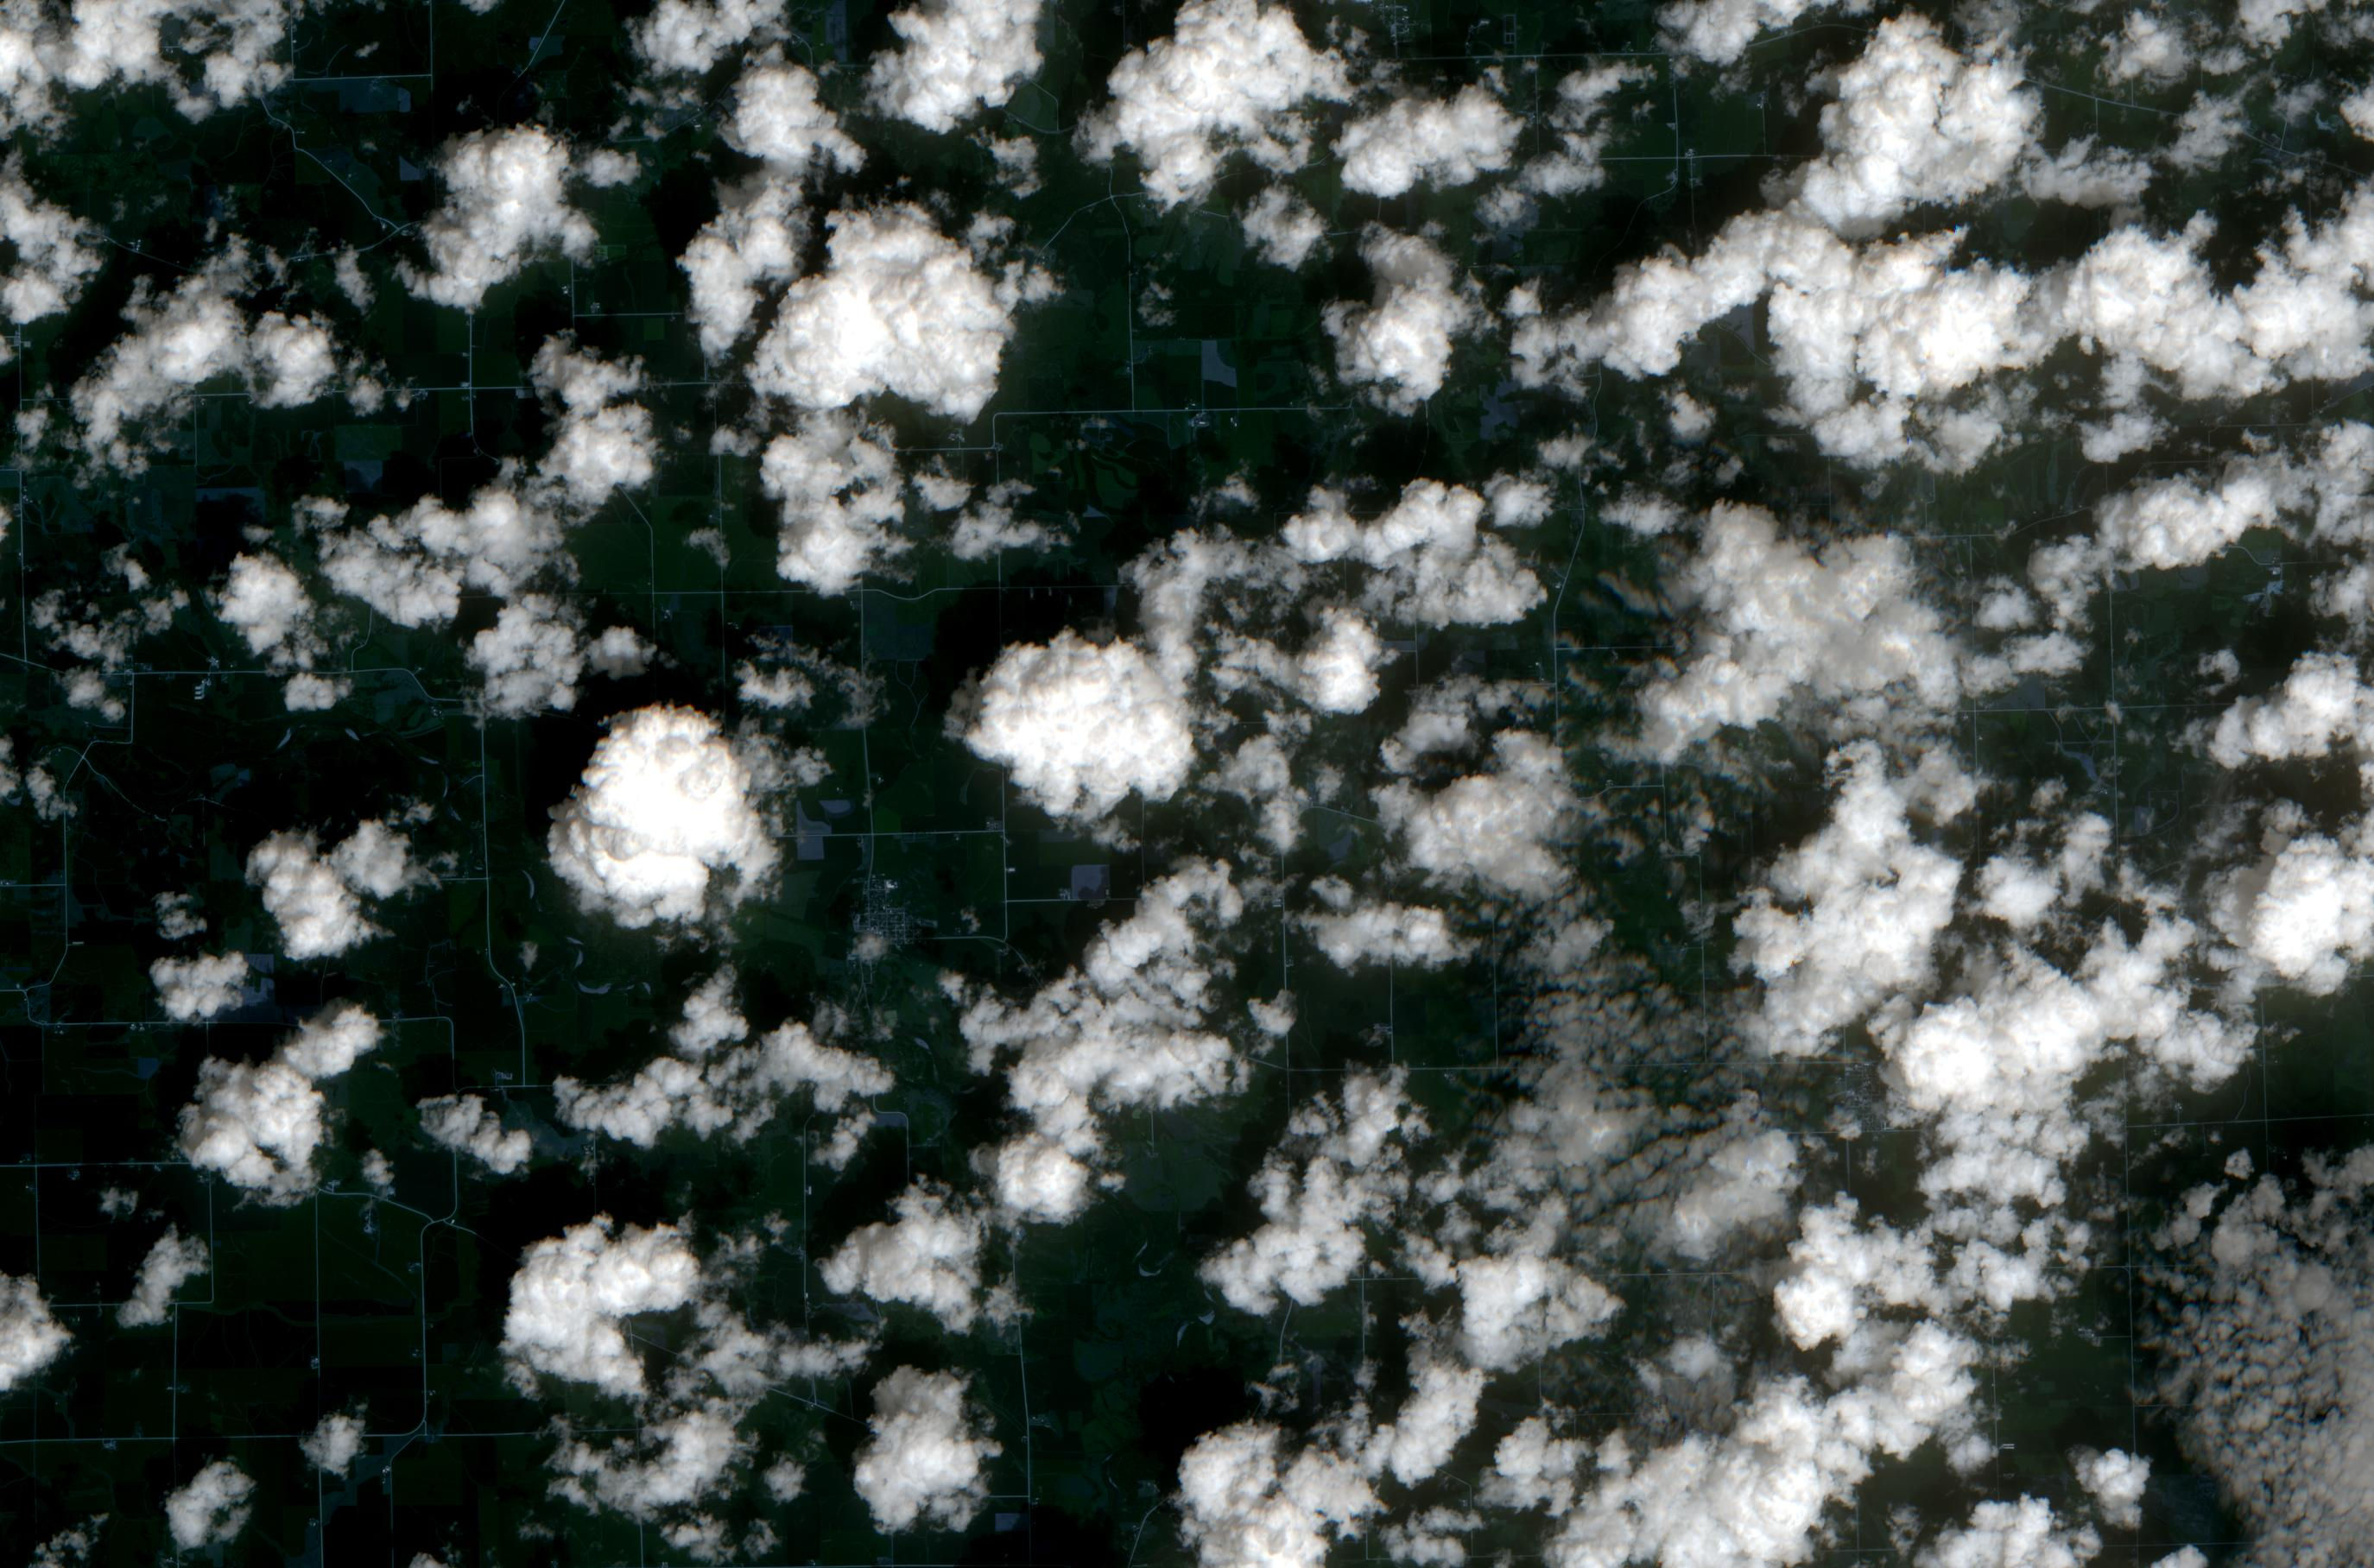

In [33]:
iowa_clouds.export_image(size=[2749,1816])

In the scene above, only clouds are present in the area of interest.

### Data Pre-processing <a class="anchor" id="14"></a>

In [34]:
iowa_clouds.name

'small_rgb_iowa3'

Here, the imagery name is rgbnir_iowa.tif, and the name of the 4 bands of blue, green, red, and near infrared are small_rgb_iowa3, small_rgb_iowa3_1, small_rgb_iowa3_2, small_rgb_iowa3_3 respectively. These bands will be used for defining the preprocessors.

In [35]:
iowa_clouds.band_names

['Band_1', 'Band_2', 'Band_3', 'Band_4']

This is a four band imagery, so the preprocessors are first defined for scaling.

In [36]:
preprocessors = [('small_rgb_iowa3', 'small_rgb_iowa3_1', 'small_rgb_iowa3_2', 'small_rgb_iowa3_3', MinMaxScaler())]

In [37]:
data = prepare_tabulardata(explanatory_rasters=[iowa_clouds], preprocessors=preprocessors)

In [38]:
data.show_batch()

,small_rgb_iowa3,small_rgb_iowa3_1,small_rgb_iowa3_2,small_rgb_iowa3_3
1846070,3928,3925,4134,5941
2499805,1430,1250,840,6298
3737905,4619,4463,4798,6414
4917480,5813,5726,6147,7259
4945138,1702,1365,989,3131


### Model Initialization <a class="anchor" id="15"></a>

Once the data is prepared, an unsupervised model of k-means clustering from scikit-learn can be used for clustering the pixels into areas of clouds and no clouds. The clustering model is passed inside an MLModel, with the number of clusters set as three for the classes of no clouds, medium clouds, and dense clouds.

In [39]:
model = MLModel(data, 'sklearn.cluster.KMeans', n_clusters=3, init='k-means++', random_state=43)

### Model Training <a class="anchor" id="16"></a>
Finally, the model is ready to be trained, labeling the pixels into the three different classes.

In [40]:
model.fit()

In [41]:
model.show_results()

,small_rgb_iowa3,small_rgb_iowa3_1,small_rgb_iowa3_2,small_rgb_iowa3_3,prediction_results
2472127,9900,9925,10355,11735,1
3128447,1220,1084,713,4867,0
3133301,4552,4091,3695,5966,2
3851622,1451,1227,951,5295,0
4301871,1501,1292,885,6157,0


### Cloud Prediction<a class="anchor" id="17"></a>

In [42]:
# creating the local output raster path
import tempfile
local_path=tempfile.gettempdir()
output_raster_path=local_path+r"/result"+str(dt.now().microsecond)+".tif"
output_raster_path

'C:\\Users\\Supratim\\AppData\\Local\\Temp/result668383.tif'

In [43]:
# predicting the cloud masks using the fitted model
pred_new = model.predict(explanatory_rasters=[iowa_clouds], 
                         prediction_type='raster',
                         output_raster_path=output_raster_path)

## Result Visualization<a class="anchor" id="18"></a>

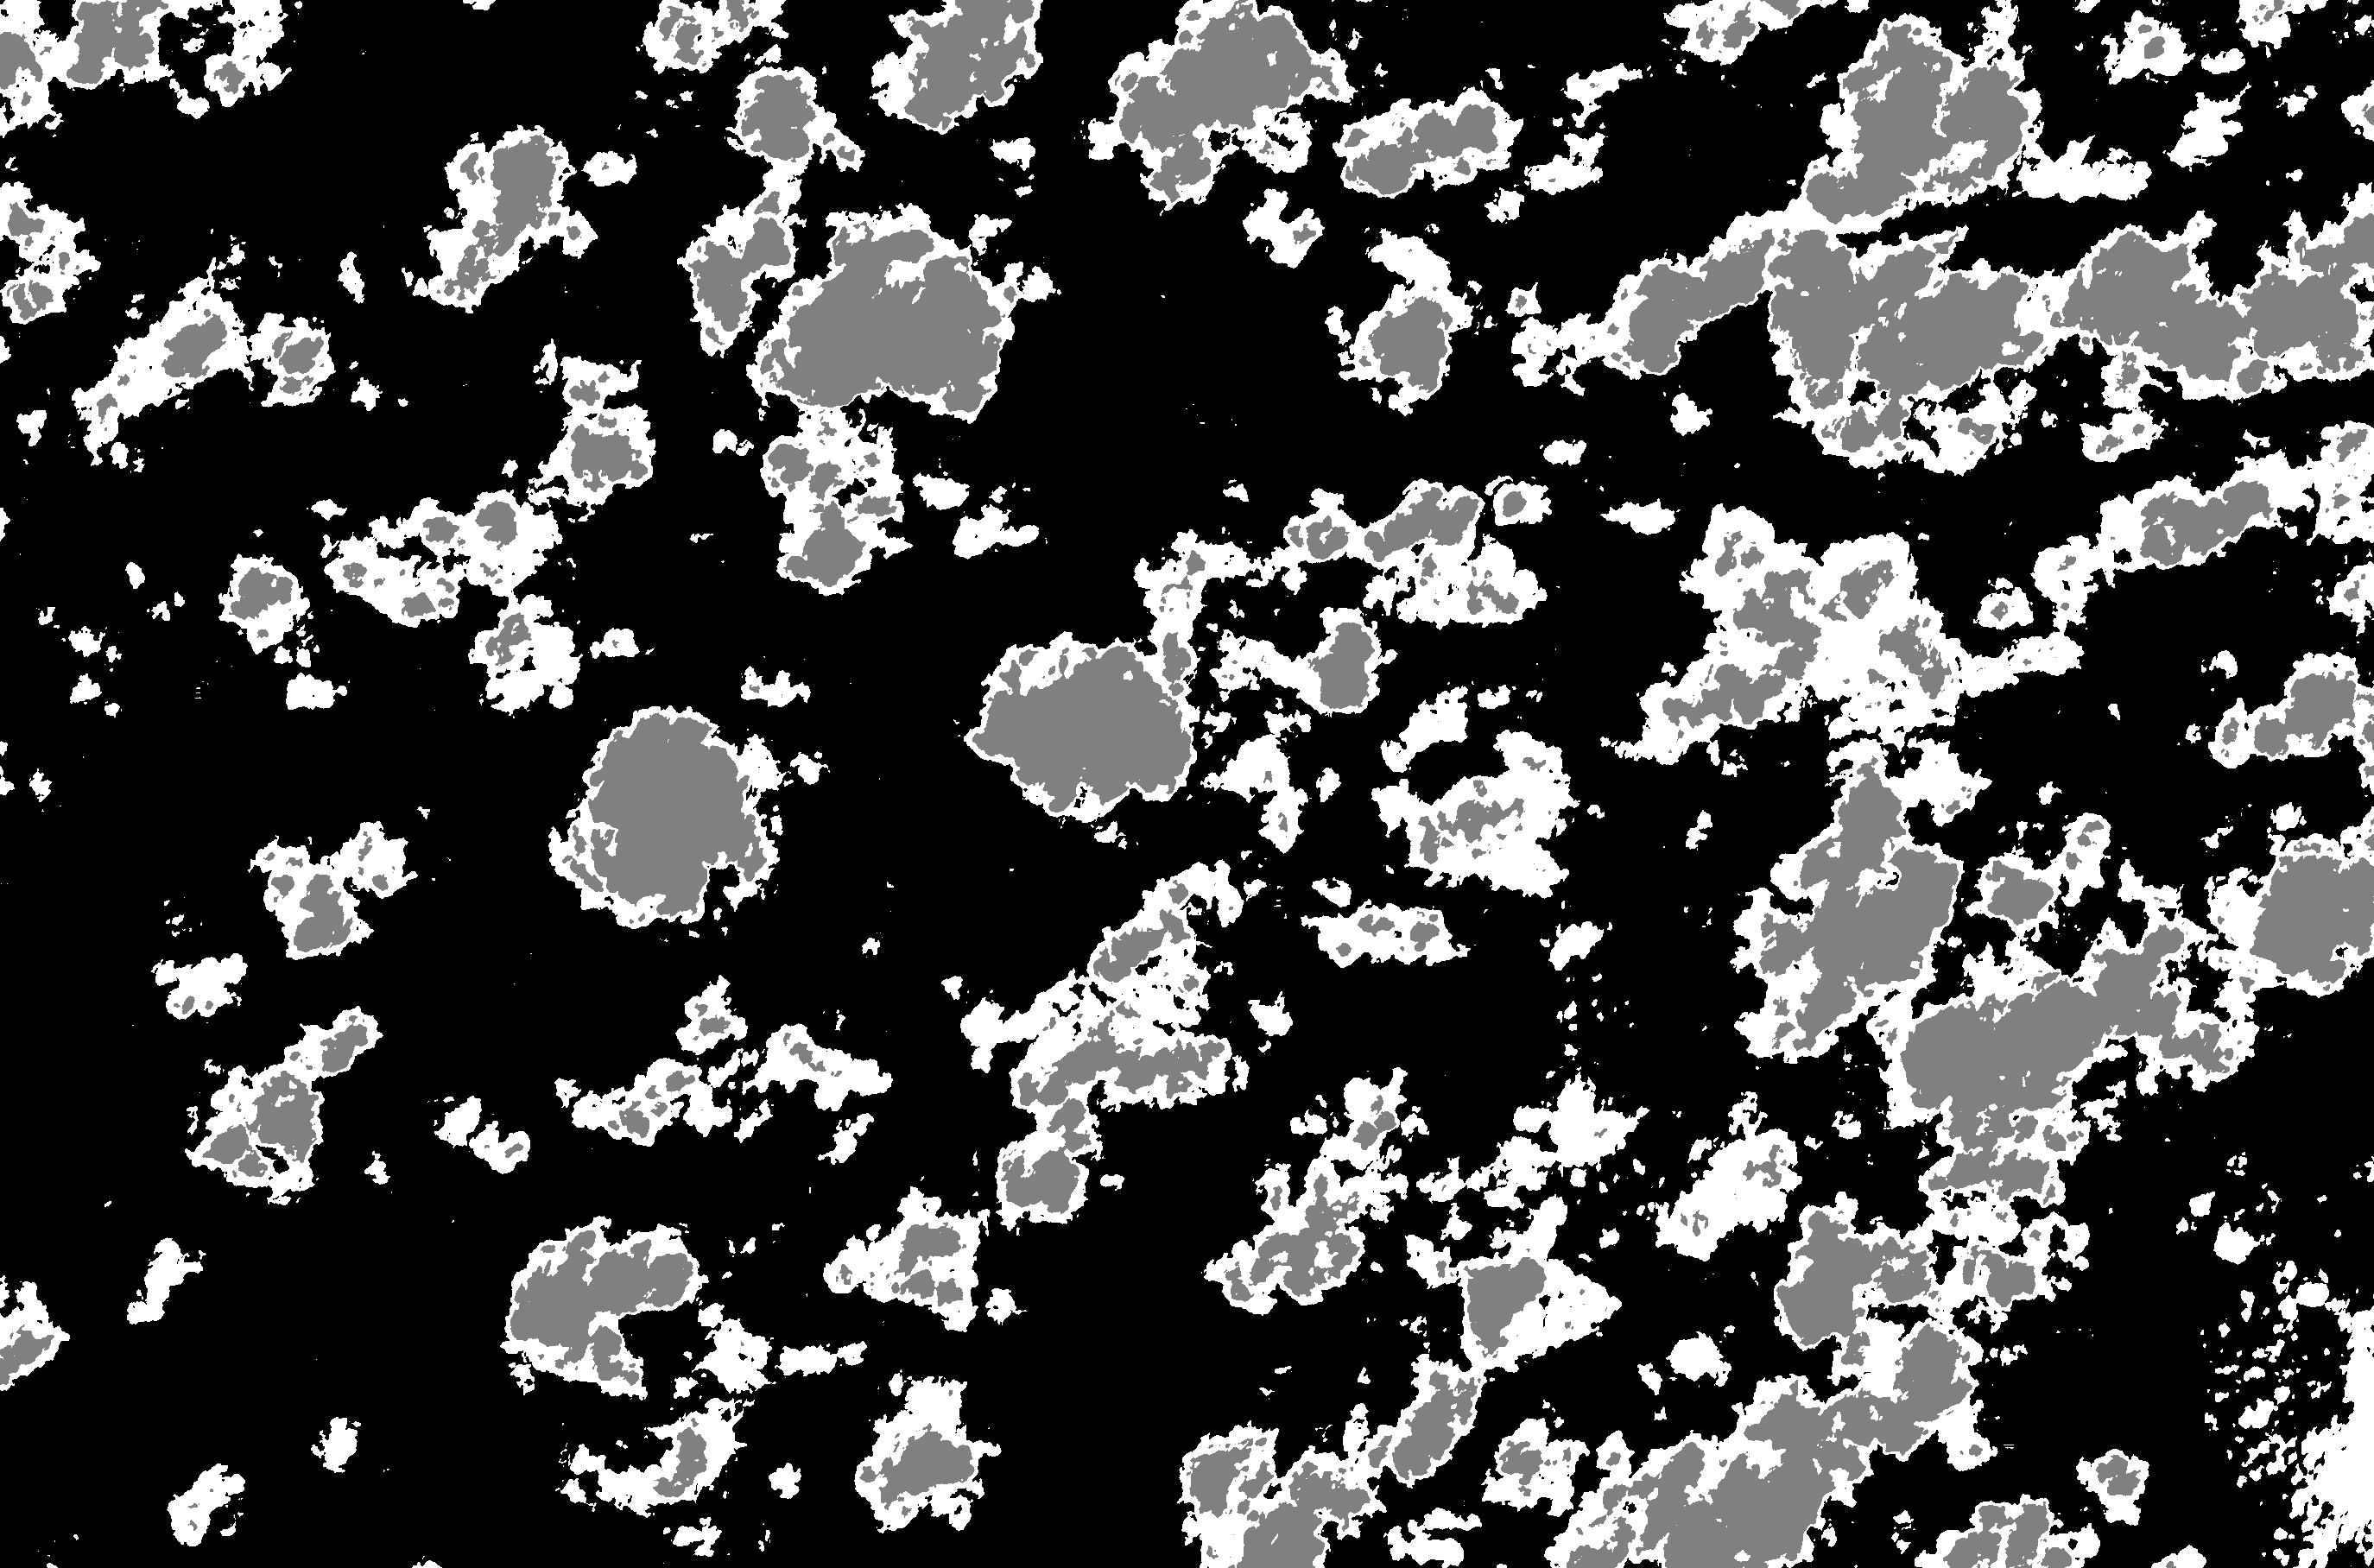

In [44]:
iowa_predicted_cloud_mask = Raster(output_raster_path)
iowa_predicted_cloud_mask.export_image(size=[2749,1816])

From the results, it can be seen that the cloud mask has been created and is represented by the white and grey pixels, while the black pixels represent areas with no cloud coverage. These results could be further reclassified to consist of two distinct classes of clouds and no-clouds in Arcgis Pro, for generating the final mask. This mask can be further processed in Arcgis Pro to create a polygon mask if needed.

## Conclusion<a class="anchor" id="19"></a>

In this sample notebook, two methods were described to create cloud masks from satellite images. A third method will be described in the second part of this notebook series.

The cloudless sentinel package performed well in detecting clouds and provides flexibility to the user to detect different intensities of clouds by changing the model's initialization parameters. However, the core caveat of this model is that it can only be used on Sentinel imagery.

The second method performed well with scenes where there were only clouds, and has the benefit of being able to run an analysis on any kind of imagery like Sentinel, Landsat, Surface reflectance etc. The model can also be used for automatically labelling training data for a pixel classification cloud detection model, which will be covered in the next part.

### Data resources <a class="anchor" id="20"></a>

| Dataset | Source | Link |
| -| - |-|
| sat imagery| sentinel2  |https://registry.opendata.aws/sentinel-2/|